# Exercise 2: Flow over a weir

## Purpose 

The purpose of this exercise is to investigate the (critical) flow over a weir. Of course, weirs are applied in numerical river models to model possible actual weirs, but they are also commonly applied to represent the many groynes present in the river model. It is well known that for the flow over a weir, energy losses are generated. These energy losses are introduced in the numerical models using (subgrid) weir formulations. The added energy loss (a sink term in the momentum equation) is based on theoretical considerations, which differ for the flow regime: subcritical or supercritical.

## Aim

For this exercise there are four aims. 

1) Investigate whether we can reproduce the theoretical energy loss that should occur over the weir at the critical discharge. <br>
2) Verify that the flow on top of the weir crest is indeed critical. <br>
3) Verify that the upstream flow condition is indeed independent of the downstream water level (when chosen low enough). <br>
4) Find out at what downstream water level, the regime changes to drowned flow. <br>

## Approach

In the current case, two-dimensional flow with a ’subgrid’ weir is considered. ’Subgrid’ refers to the fact that the weir
is represented as a thin wall on a cell edge. Another option would be to represent the weir as an
increased bed level in one/more cell(s), which would mean that the grid resolution would determine
how well the weir is resolved. To avoid this, the weir is represented by a vertical ’wall’ on a cell face.
In other words, the bottom topography is flat, i.e. all cells have a constant flat bed, only one cell edge
(with two cell corners) has a raised bed level.

The flow condition over a weir may be subcritical (drowned weir flow) or supercritical (perfect weir flow). 
The flow regime depends on the downstream water level and the flow discharge. For the perfect weir situation, the flow on top of the weir crest is critical and the discharge is the maximum possible discharge over the weir: $Q_{critical}$. For supercritical flow, the discharge at the weir is completely determined by the energy head upstream. In such a case, the discharge is limited by:

$Q_{critical} = B\frac{2}{3}E_{up}\sqrt{\frac{2}{3}gE_{up}}$ .

## Model description

The channel length $L$ is 300 m and its width $B$ is 90 m. The Chézy coefficient is $C$ = 100 m$^{1/2}$/s (smooth bed). At the upstream boundary we will prescribe the theoretical (critical) discharge and the downstream boundary a water level of $\zeta$ =  1.7 m. The weir crest height is 1.0 m above the bottom of the channel.

The channel is simulated on a grid with cell sizes equal to 10 x 10 m. The grid and the rest of the model components are displayed in Figure 1.

<img src="./figures/grid_with_weir_bcs_and_obs.png" alt="Drawing" style="float: left" style="width: 800px;"/>

Figure 1: Computational grid for the flow over a weir. The bed level is 0.0 m (w.r.t. reference), except at the cell edges where the weir is located, at which the bed level is 1.0 m (w.r.t. reference). The flow is from left to right. The "eye" symbols mark the observation points used to study the output time series.

The energy head upstream of the weir(w.r.t. the weir crest level) is:

$E_{up} = \zeta_{up} - z_c + \frac{u_{up}^2}{2g}$

where $z_c$ is the crest level of the weir. $E_{up}$ is approximately equal to the difference between the upstream water level and the crest level, i.e. 1.0 m. The exact value, however, depends on the flow velocity upstream, which in turn depends on the discharge. The velocity/discharge can be computed by solving a cubic relation. The resulting critical discharge is:

$Q_{critical} =  163.182 m ^3/s$ .

The corresponding velocity is $u_{up}$ = 0.9066 m/s ($Q = u B H$). Its derivation is available upon request. The resulting exact upstream energy head is thus $E_{up}$ = 1.0419 m. 
On top of the weir, the Froude number $Fr = u/\sqrt{gH} = 1$. The flow velocity on the crest can be verified to be $u_c$ = 2.6104 m/s, with a corresponding depth at the crest of $H_c$ = 0.6946 m. This can be derived by assuming a constant energy head from the upstream section to the weir crest section (see the appendix). Indeed, this depth corresponds with the theoretical value of $H_c$ = 2/3 $E_{up}$.

Now we can start the exercise. Follow the steps below to inspect the different model states (perfect and drowned weir flow) and try different settings for the model parameters.

## Step 2a)

Specify the critical discharge at the upstream boundary and a water level of 1.7 m at the downstream boundary, corresponding to the perfect (supercritical) weir flow situation described above. Verify that indeed such a flow situation is reproduced by the model. Do we obtain the correct upstream water level of $\zeta_{up}$ = 2 m? Is the flow indeed critical on the weir crest?

One can see that the energy loss due to a single weir (in the perfect weir flow regime), is $\Delta H$ = 0.30 m, which is 15 % of the total water depth for this case (which is not uncommon). This is quite a significant loss. In the final exercise ("The flow over and around a groyne"), we will compare this energy loss to that of a groyne, where the flow can also go aroung the hydraulic structure.

## Step 2b)

Where does the energy loss occur? Why is there no energy loss in the flow contraction before the weir?
What happens if we lower the Chézy bed roughness, increasing the bottom friction?

## Step 2c)

Slightly lower or raise the downstream water level. Does anything change in the upstream region?
What happens if you raise the downstream water level further? Can you find the point (i.e. the value of the downstream water level) at which the weir flow regime changes to "drowned weir flow"?

Is the flow now indeed everywhere subcritical?

With this new downstream water level, can you find the (higher) discharge that again transforms the flow to a perfect weir flow? What is now the energy loss over the weir?

This concludes this exercise.

In [1]:
# Imports
import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import logging
import threading
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
_ = plt.figure()
plt.ion()

# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [2]:
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM-old\share\bin\dflowfm'
wrapper = bmi.wrapper.BMIWrapper(engine=engine);
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM\x64\dflowfm\bin\dflowfm'
mdufile = r'C:\Users\vries_cy\PAOTM cursus\c080_critical_flow_over_subgrid_weir\weir01_Q-H.mdu'

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
wrapper.initialize()

In [4]:
# for i in range(wrapper.get_var_count()):
#     print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

In [5]:
maxsteps = 100
parameters = [
    {
        "parameter": "zbndz",
        "description": "Boundary Water level Downstream $[m]$",
        "default": str(wrapper.get_var('zbndz')[0])
    },    {
        "parameter": "zbndq",
        "description": "Boundary Discharge Upstream $[m^3/s]$",
        "default": str(wrapper.get_var('zbndq')[0])
    },    {
        "parameter": "frcu",
        "description": r"Roughness Chézy $[\sqrt{m}/s]$",
        "default": str(wrapper.get_var("frcu")[0])
    }
]

In [6]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=100,
    min=0,
    max=100,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [7]:
# wrapper.get_end_time()

In [8]:
# Model specific function 
g = 9.81
B = 90
#     Automate parameter and grid sizes
def update_data():
    yz = wrapper.get_var('yz')
    cond = (yz > 45) & (yz < 47)
    waterlevel = wrapper.get_var('s1')[cond][:-1]
    bedlevel = wrapper.get_var('bl')[cond][:-1]
    xz = wrapper.get_var('xz')[cond][:-1]
    ucx = wrapper.get_var('ucx')[cond][:-1]
    h = waterlevel.copy()
    
#     Due to the grid staggering, the Froude number based on the circumcentre ucx 
#     is not the correct critical value at the crest(1)
    h[14] -= 1
    E = (ucx ** 2 / (2*g)) + waterlevel.copy()
    Hc = ((E[0] - 1) * 2 ) / 3
    Q = wrapper.get_var('zbndq')[0]
    uc = Q / (B * Hc)
    Fr = (abs(ucx) / np.sqrt(g * h))
    Fr[14] = (abs(uc) / np.sqrt(g * Hc))
    data.append(dict({
        "time": wrapper.get_current_time(),
        "waterlevel": waterlevel.copy(), 
        "bedlevel": bedlevel.copy(), 
        "xz": xz, 
        "energyhead": E, 
        "fr": Fr
    }))
    slider.max = len(data)
    slider.description="timestep: {}".format(data[slider.value]["time"])
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [9]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
    print(n)
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    slider.value = 0
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


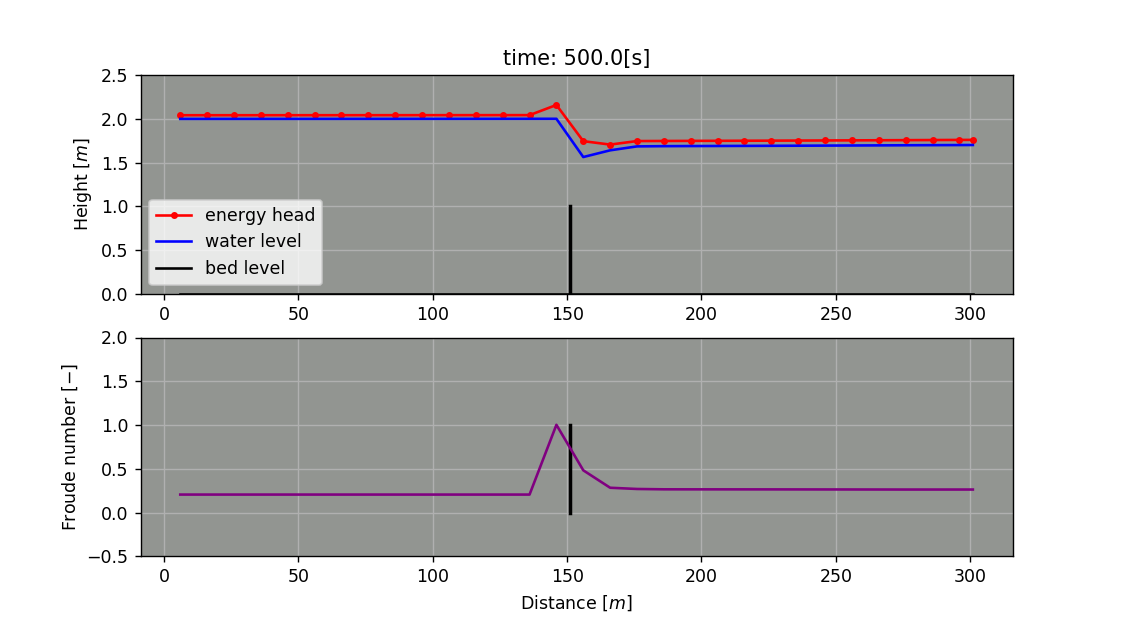

(-0.5, 2)

100


In [10]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 5) # (w, h)

# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    if (t < len(data)):
        wlp.set_data(data[t]["xz"], data[t]["waterlevel"])
        blp.set_data(data[t]["xz"], data[t]["bedlevel"])
        ehead.set_data(data[t]["xz"], data[t]["energyhead"])
        ax1.set_title("time: " + str(data[t]["time"]) + "[s]")
        fr.set_data(data[t]["xz"], data[t]["fr"])
        fig.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))
fig, (ax1, ax2) = plt.subplots(2, 1)
display(player)

ehead, = ax1.plot(data[0]["xz"], data[0]["energyhead"],'.-', color="red", label="energy head")
wlp, = ax1.plot(data[0]["xz"], data[0]["waterlevel"], color="blue", label="water level")    
blp, = ax1.plot(data[0]["xz"], data[0]["bedlevel"], color="black", label="bed level") 
ax1.plot([151, 151], [0, 1], "black", linewidth=2)
ax1.set_ylim(0, 2.5)
ax1.set_facecolor('xkcd:grey')
ax1.grid()
ax1.set_ylabel("Height $[m]$")
ax1.legend()
ax1.set_title("time: " + str(data[0]["time"]) + "$[s]$")
ax2.plot([151, 151], [0, 1], "black", linewidth=2)
fr, = ax2.plot(data[0]["xz"], data[0]["fr"], color="purple", label=r"Froude $[-]$") 
ax2.set_xlabel("Distance $[m]$")
ax2.set_ylabel("Froude number $[-]$")
ax2.set_facecolor('xkcd:grey')
ax2.grid()
ax2.set_ylim(-0.5, 2)